In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,1,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,3,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# 输入标准化
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#输出标准化
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#测试集标准化
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))


_temp_train_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))
_temp_train_label = x_train_label

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label


_temp_train_input_for_NN = x_train_input

_temp_test_input_for_NN = x_test_input


dataset = dict()
dataset_ = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset_['train_input_for_NN'] = torch.tensor(_temp_train_input_for_NN.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset_['test_input_for_NN'] = torch.tensor(_temp_test_input_for_NN.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# dataset['test_input'] = torch.tensor(np.array(X_test)[:,:32])
# dataset['test_label'] = torch.tensor(np.array(y_test))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



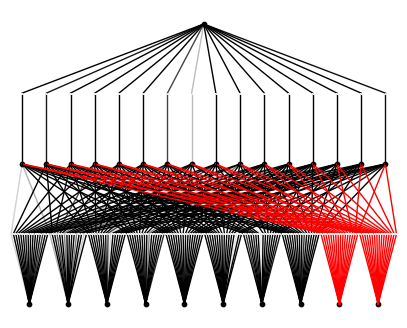

In [2]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[10,16,1], grid=10, k=3, seed=0, device=device)# create dataset f(x,y) = exp(sin(pi*x)+y^2)

model(dataset['train_input']);

for i in range(16):
    model.fix_symbolic(0,9,i,'sin',fit_params_bool=False)
    model.fix_symbolic(0,8,i,'sin',fit_params_bool=False)

# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100);

In [3]:
# train the model
start_time = time.time()
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01, lamb_entropy=10.);
end_time = time.time()
print(end_time - start_time)

train loss: 4.12e-01 | test loss: 6.12e-01 | reg: 9.75e+01 : 100%|██| 50/50 [00:44<00:00,  1.11it/s]

44.86917209625244


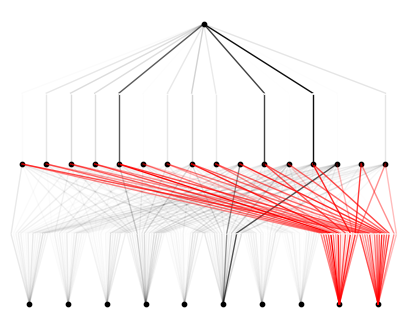

In [4]:
model.plot()

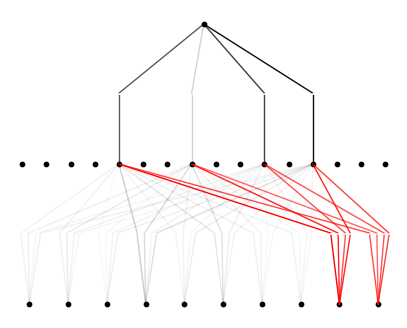

In [5]:
model.prune(threshold=5e-2)
model.plot(mask=True)

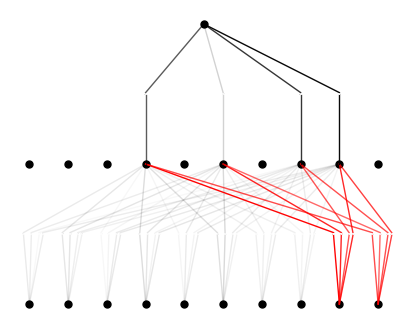

In [6]:
model = model.prune()
model(dataset['train_input'])
model.plot()

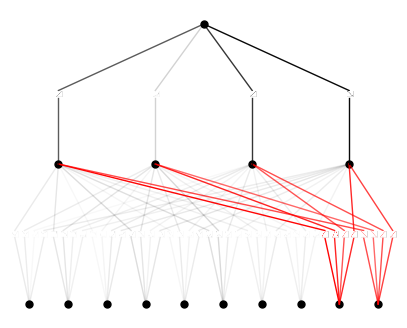

In [7]:
model = model.prune(5e-2)
model(dataset['train_input'])
model.plot()

In [8]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 2.59e-01 | test loss: 5.61e-01 | reg: 1.53e+01 : 100%|██| 50/50 [00:15<00:00,  3.16it/s]


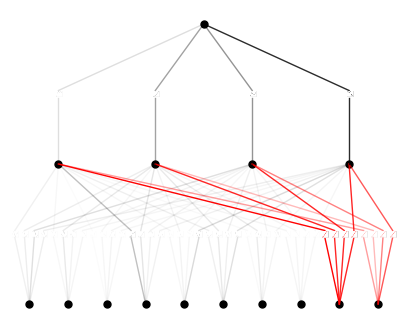

In [9]:
model.plot()

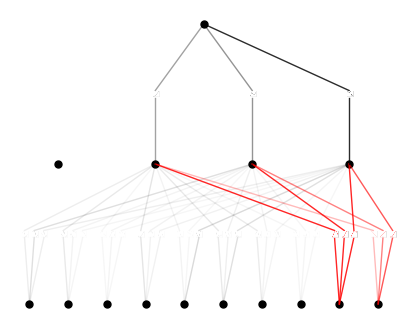

In [10]:
model.prune(threshold=5e-2)
model.plot(mask=True)

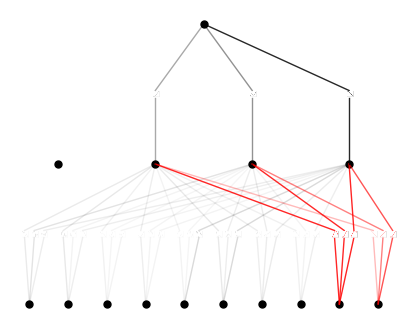

In [11]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [12]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 3.43e-01 | test loss: 4.82e-01 | reg: 1.23e+01 : 100%|██| 50/50 [00:16<00:00,  3.09it/s]


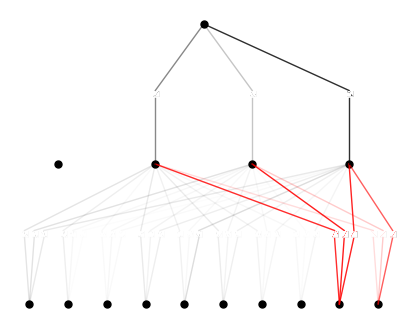

In [13]:
model.plot()

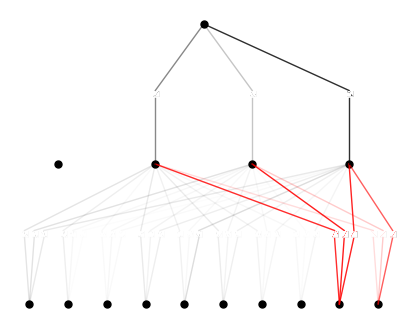

In [14]:
model.prune(threshold=5e-2)
model.plot(mask=True)

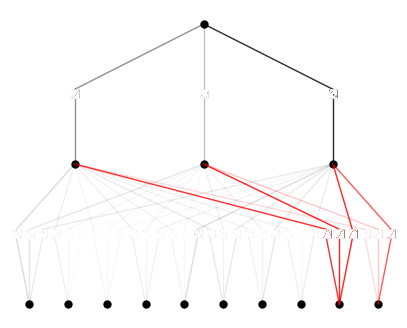

In [15]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [16]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 2.88e-01 | test loss: 5.02e-01 | reg: 1.19e+01 : 100%|██| 50/50 [00:15<00:00,  3.23it/s]


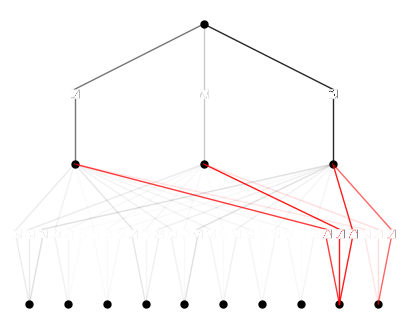

In [17]:
model.plot()

In [18]:
inter_units = 3
func_0 = []
for i in range(10):
    for j in range(inter_units):
        func_0.append(model.suggest_symbolic(0,i,j)[0])

func_1 = []
for i in range(inter_units):
    for j in range(1):
        func_1.append(model.suggest_symbolic(1,i,j)[0])

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i in range(10):
    for j in range(inter_units):
        model.fix_symbolic(0,i,j,func_0[i*inter_units+j],fit_params_bool=True)
for i in range(inter_units):
    for j in range(1):
        model.fix_symbolic(0,i,j,func_1[i*1+j],fit_params_bool=True)

function , r2
tanh , 0.8819320797920227
sigmoid , 0.8719030022621155
arctan , 0.8591330051422119
sgn , 0.8348141312599182
gaussian , 0.8280127644538879
function , r2
gaussian , 0.982706606388092
sin , 0.9823879599571228
tanh , 0.9612306952476501
sigmoid , 0.9612287878990173
arctan , 0.9549450278282166
function , r2
gaussian , 0.9174298644065857
tanh , 0.9148247241973877
sigmoid , 0.9148238897323608
arctan , 0.8931652307510376
sin , 0.859347939491272
function , r2
gaussian , 0.9222137331962585
sin , 0.8639020919799805
abs , 0.6717430353164673
tanh , 0.4242002069950104
sigmoid , 0.42270058393478394
function , r2
gaussian , 0.8930007219314575
sin , 0.8843176364898682
tanh , 0.8777019381523132
sigmoid , 0.8776970505714417
arctan , 0.8628427982330322
function , r2
gaussian , 0.7564460635185242
sin , 0.5670838952064514
tanh , 0.46421077847480774
sigmoid , 0.44703319668769836
sgn , 0.4260530471801758
function , r2
gaussian , 0.7156316041946411
abs , 0.6733726263046265
sin , 0.558341920375824


In [19]:
model.train(dataset, opt="LBFGS", lr=0.01, steps=50, batch=128, lamb=0.01);

train loss: 3.76e-01 | test loss: 5.13e-01 | reg: 1.17e+01 : 100%|██| 50/50 [00:17<00:00,  2.89it/s]


In [20]:
model.symbolic_formula()[0]

[107.52*cosh(0.02*(-0.11*x_4 - 1)**2 + 0.02*sin(0.52*x_10 - 3.22) + 0.01*sin(3.19*x_2 + 8.2) - 0.01*sin(0.76*x_6 + 2.17) - 0.11*sin(1.31*x_9 - 8.24) - 0.01*tanh(7.49*x_1 + 2.74) + 0.06 + 0.02*exp(-4.83*(-x_8 - 0.29)**2) + 0.02*exp(-3.22*(-0.98*x_5 - 1)**2) + 0.01*exp(-8.34*(-x_3 - 0.58)**2) - 0.01*exp(-9.17*(0.18 - x_7)**2)) - 7.33*cosh(0.32*sin(1.0*x_10 + 2.78) - 0.04*sin(3.69*x_4 + 5.02) + 0.07*sin(2.04*x_5 - 2.94) + 0.05*sin(5.82*x_7 - 2.0) - 0.23*sin(0.7*x_9 + 7.56) - 0.e-2*tan(0.38*x_6 + 5.9) - 0.04*atan(5.4*x_8 - 1.69) - 0.17 + 0.18*exp(-2.81*(0.9 - x_1)**2) + 0.08*exp(-12.95*(0.66 - x_3)**2) + 0.03*exp(-14.94*(0.03 - x_2)**2)) - 100.93]

In [21]:
from xgboost import XGBRegressor as XGBR
start_time = time.time()
XGBR_reg = XGBR(n_estimators=100).fit(dataset['train_input'].detach().numpy(), dataset['train_label'].detach().numpy())
XGBR_pre = XGBR_reg.predict(dataset['test_input'].detach().numpy())
end_time = time.time()
print(end_time - start_time)

0.10497617721557617


In [22]:
loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label']), batch_size=128, shuffle=True)

num_inputs, num_outputs= 10, 1
net_1 = nn.Sequential()
net_1.add_module('linear1',nn.Linear(num_inputs,16))
net_1.add_module('sigmoid',nn.Sigmoid())
net_1.add_module('linear2',nn.Linear(16,1))

net_2 = nn.Sequential()
net_2.add_module('linear1',nn.Linear(num_inputs,2))
net_2.add_module('sigmoid',nn.Sigmoid())
net_2.add_module('linear2',nn.Linear(2,1))

In [23]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]
    

In [24]:
loss_func_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(net_1.parameters(), lr = 0.01)
loss_func_2 = torch.nn.MSELoss()
optimizer_2 = torch.optim.Adam(net_2.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(50):
    for step, (x,y) in enumerate(loader):          # for each training step
        output = net_1(x)                           # get output for every net
        loss_1 = loss_func_1(output, y)                # compute loss for every net
        optimizer_1.zero_grad()                             # clear gradients for next train
        loss_1.backward()                             # backpropagation, compute gradients
        optimizer_1.step()                                  # apply gradients
end_time = time.time()
print(end_time - start_time)

start_time = time.time()
for epoch in range(50):
    for step, (x,y) in enumerate(loader):          # for each training step
        output = net_2(x)                           # get output for every net
        loss_2 = loss_func_2(output, y)                # compute loss for every net
        optimizer_2.zero_grad()                             # clear gradients for next train
        loss_2.backward()                             # backpropagation, compute gradients
        optimizer_2.step()                                  # apply gradients
end_time = time.time()
print(end_time - start_time)

0.7735507488250732
0.647305965423584


In [25]:
pre_ann_1 = net_1.forward(dataset['test_input']).detach().numpy()
pre_ann_2 = net_2.forward(dataset['test_input']).detach().numpy()
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_ann_1_ = scaler_output.inverse_transform(pre_ann_1)
pre_ann_2_ = scaler_output.inverse_transform(pre_ann_2)
pre_KAN_ = scaler_output.inverse_transform(pre_KAN)
XGBR_pre_ = scaler_output.inverse_transform(XGBR_pre.reshape(-1,1))

result = dict()
result["ann_1"] = evaluation(pre_ann_1_,actual)
result["ann_2"] = evaluation(pre_ann_2_,actual)
result["KAN"] = evaluation(pre_KAN_,actual)
result["XGBR"] = evaluation(XGBR_pre_,actual)

In [26]:
result

{'ann_1': [406.801512664093, 314.06436237959787, 0.04059749326995012],
 'ann_2': [495.0686320204994, 390.2696667519858, 0.050893092398240775],
 'KAN': [390.5055483920252, 304.2105579646049, 0.039844633440589826],
 'XGBR': [380.44526050167, 278.9111510655078, 0.036678279620587034]}

In [27]:
# class SiLU(nn.Module):
#     @staticmethod
#     def forward(x):
#         return x * torch.sigmoid(x)

# 定义第一个模块
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(10, 16)
        self.fc2 = nn.Linear(16, 1)
        self.silu_layer = torch.nn.SiLU()

 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.silu_layer(x)
        return x

In [28]:
# 连接模块
class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1
        self.module2 = module2
        self.fc1 = nn.Linear(2,1)
 
    def forward(self, x1, x2):
        # with torch.no_grad():
        y1 = self.module1(x1)
        y2 = self.module2(x2)  
        y = self.fc1(torch.cat((y1,y2), 1))
        return y

    def loss_func(self, x1, x2, y_actual):
        y_pre = self.forward(x1,x2)
        loss = torch.mean((y_pre-y_actual)**2)
        _W_loss = []
        for _i,_j in enumerate(KAN_ADD_NN.fc1.parameters()):
            if _i == 0:
                loss += 10*torch.mean(torch.abs(_j[:,1]))
            
        return loss
 

In [29]:
module2 = NN()
# 实例化复合模块
KAN_ADD_NN = KAN_ADD_NN(model, module2)
loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'],dataset['train_input'], dataset['train_label']), batch_size=128, shuffle=True)

In [30]:
# loss_func_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(KAN_ADD_NN.parameters(), lr = 0.01)

for epoch in range(100):
    for step, (x,y,z) in enumerate(loader):          # for each training step
        output = KAN_ADD_NN(x,y)                           # get output for every net
        loss_1 = KAN_ADD_NN.loss_func(x, y, z)                # compute loss for every net
        optimizer_1.zero_grad()                             # clear gradients for next train
        loss_1.backward()                             # backpropagation, compute gradients
        optimizer_1.step()                                  # apply gradients


In [31]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]
    

In [32]:
pre_ann_3 = KAN_ADD_NN.forward(dataset['test_input'],dataset['test_input']).detach().numpy()
actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_ann_3_ = scaler_output.inverse_transform(pre_ann_3)
result = dict()
result["KAN+ANN"] = evaluation(pre_ann_3_,actual)

In [33]:
result

{'KAN+ANN': [346.3045401123196, 267.4635385035826, 0.03472927647740034]}

In [34]:
for _i,_j in enumerate(KAN_ADD_NN.fc1.parameters()):
    if _i == 0:
        print("Weighted Coefficients: ",_j.detach().numpy()[0])
    if _i == 1:
        print("Bias: ",_j.detach().numpy()[0])

Weighted Coefficients:  [-7.2564548e-01 -3.3149327e-04]
Bias:  -0.49968588


In [35]:
pre_ann_4 = KAN_ADD_NN.module1(dataset['test_input']).detach().numpy()
pre_ann_4_ = scaler_output.inverse_transform(-7.2564548e-01*pre_ann_4-0.49968588)
result["Revised KAN"] = evaluation(pre_ann_4_,actual)

In [36]:
result

{'KAN+ANN': [346.3045401123196, 267.4635385035826, 0.03472927647740034],
 'Revised KAN': [346.2148851442422, 267.3884965820343, 0.034719851564232934]}

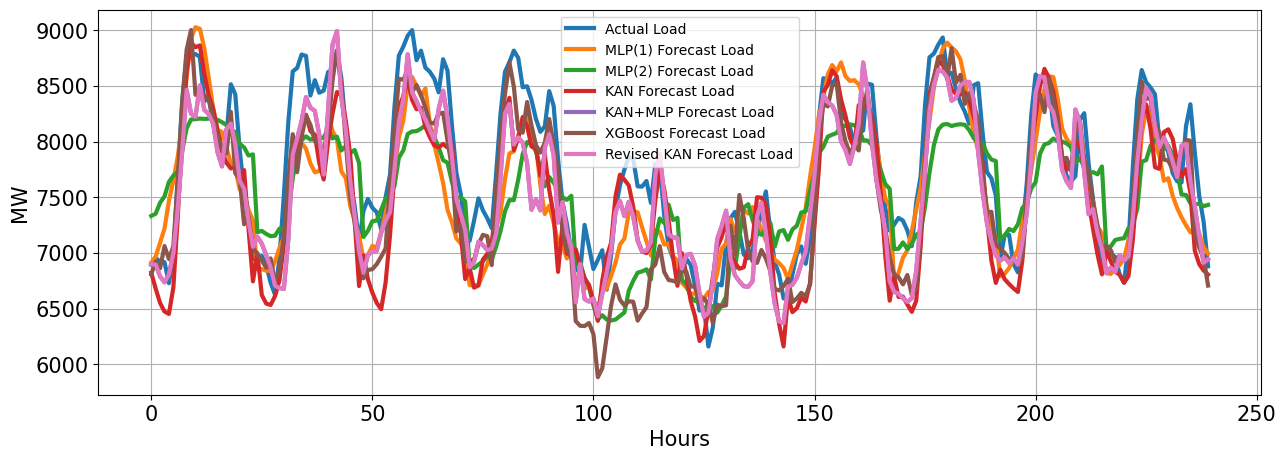

In [37]:
f = plt.figure(figsize=(15,5))
plt.plot(actual[:240],linewidth=3,label="Actual Load")
plt.plot(pre_ann_1_[:240],linewidth=3,label="MLP(1) Forecast Load")
plt.plot(pre_ann_2_[:240],linewidth=3,label="MLP(2) Forecast Load")
plt.plot(pre_KAN_[:240],linewidth=3,label="KAN Forecast Load")
plt.plot(pre_ann_3_[:240],linewidth=3,label="KAN+MLP Forecast Load")
plt.plot(XGBR_pre_[:240],linewidth=3,label="XGBoost Forecast Load")
plt.plot(pre_ann_4_[:240],linewidth=3,label="Revised KAN Forecast Load")
# plt.ylim(6500,8000)
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours",fontsize=15)
plt.ylabel("MW",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
f.savefig("./COMPARE_SPRING.svg",format="svg",dpi=300)